# UltraGCN on ML-100k

Nowadays, personalized recommendation has become a prevalent way to help users find information of their interests in various applications, such as e-commerce, online news, and social media. The core of recommendation is to precisely match a user’s preference with candidate items. Collaborative filtering (CF), as a fundamental recommendation task, has been widely studied in both academia and industry. A common paradigm of CF is to learn vector representations (i.e., embeddings) of users and items from historical interaction data and then perform top-k recommendation based on the pairwise similarity between user and item embeddings.

As the interaction data can be naturally modelled as graphs, such as user-item bipartite graph and item-item co-occurrence graph, recent studies opt for powerful graph convolutional/neural networks (GCNs, or GNNs in general) to learn user and item node representations. These GCN-based models are capable of exploiting higher-order connectivity between users and items, and therefore have achieved impressive performance gains for recommendation. PinSage and M2GRL are two successful use cases in industrial applications.

## Primer - GCN

GCN is a representative model of graph neural networks that applies message passing to aggregate neighborhood information. The message passing layer with self-loops is defined as follows:

$$E^{(l+1)} = \sigma(\hat{D}^{-1/2} \hat{A}\hat{D}^{-1/2}E^{(l)}W^{(l)})$$

where,

- $\hat{A} = A + I$, and $\hat{D} = D + I$
- $𝐴$, $𝐷$, $𝐼$ are the adjacency matrix, the diagonal node degree matrix, and the identity matrix, respectively
- $𝐼$ is used to integrate self-loop connections on nodes
- $𝐸^{(𝑙)}$ and $W^{(𝑙)}$ denote the representation matrix and the weight matrix for the $𝑙$-th layer
- $\sigma(·)$ is a non-linear activation function (e.g., ReLU).

LightGCN is the simplified GCN model that removes feature transformations (i.e., $𝑊^{(𝑙)}$) and non-linear activations (i.e., 𝜎). Its message passing layer can thus be expressed as follows:

$$E^{(l+1)} = (\hat{D}^{-1/2} \hat{A}\hat{D}^{-1/2}E^{(l)})$$

Given self-loop connections, we can rewrite the message passing operations for user 𝑢 and item 𝑖 as follows:

$$e_u^{(l+1)} = \dfrac{1}{d_u + 1} e_u^{(l)} + \sum_{k \in \mathcal{N}(u)} \dfrac{1}{\sqrt{d_u+1}\sqrt{d_k+1}} e_k^{(l)}$$

$$e_i^{(l+1)} = \dfrac{1}{d_i + 1} e_i^{(l)} + \sum_{v \in \mathcal{N}(i)} \dfrac{1}{\sqrt{d_i+1}\sqrt{d_i+1}} e_v^{(l)}$$

where,

- 𝑢 and 𝑣 denote users while 𝑖 and 𝑘 denote items
- $e_u^{(l)}$ and $e_i^{(l)}$ denote the embeddings of user 𝑢 and item 𝑖 at layer 𝑙
- $\mathcal{N}(𝑢)$ and $\mathcal{N}(𝑖)$ represent their neighbor node sets, respectively
- $𝑑_𝑢$ denotes the original degree of the node 𝑢.

LightGCN takes the dot product of the two embedding as the final logit to capture the preference of user 𝑢 on item 𝑖. Thus we obtain:

$$e_u^{(l+1)} \cdot e_i^{(l+1)} = \alpha_{ui}(e_u^{(l)} \cdot e_i^{(l)}) + \sum_{k \in \mathcal{N}(u)}\alpha_{ik}(e_i^{(l)} \cdot e_k^{(l)}) + \sum_{v \in \mathcal{N}(i)}\alpha_{uv}(e_u^{(l)} \cdot e_v^{(l)}) + \sum_{k \in \mathcal{N}(u)}\sum_{v \in \mathcal{N}(i)}\alpha_{kv}(e_k^{(l)} \cdot e_v^{(l)})$$

Therefore, we can observe that multiple different types of collaborative signals, including user-item relationships (𝑢-𝑖 and 𝑘-𝑣), item-item relationships (𝑘-𝑖), and user-user relationships (𝑢-𝑣), are captured when training GCN-based models with message passing layers. This also reveals why GCN-based models are effective for CF.

## Problem Statement

Industrial recommender systems usually involve massive graphs due to the large numbers of users and items. However, current GCN-based models are hard to train with large graphs, which hinders their wide adoption in industry. This brings efficiency and scalability challenges for model designs. Some efforts have been made to simplify the design of GCN-based CF models, mainly by removing feature transformations and non-linear activations that are not necessary for CF. These proved beneficial. But it has been seen that message passing (i.e., neighborhood aggregation) on a large graph is usually time-consuming for CF. In particular, stacking multiple layers of message passing could lead to the slow convergence of GCN-based models on CF tasks. For example, in our experiments, three-layer LightGCN takes more than 700 epochs to converge to its best result on the Amazon Books dataset, which would be unacceptable in an industrial setting.

<p><center><figure>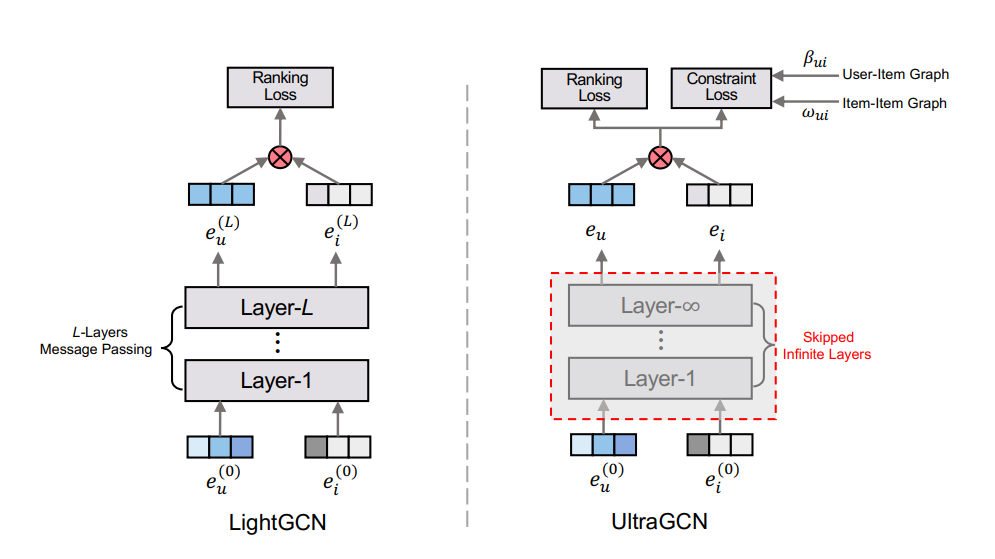<figcaption>Illustrations of training of LightGCN (left) and UltraGCN (right). LightGCN needs to recurrently perform 𝐿- layers message passing to get the final embeddings for training, while UltraGCN can “skip” such message passing to make the embeddings be directly trained, largely improving training efficiency and helping real deployment.</figcaption></figure></center></p>

UltraGCN approximates the limit of infinite-layer message passing via a constraint loss.

UltraGCN has the following optimization objective:

$$\mathcal{L} = \mathcal{L}_O + \lambda \mathcal{L}_C$$

where 𝜆 is the hyper-parameter to control the importance weights of two loss terms.

Moreover, except for user-item relationships, some other relationships (e.g., item-item and user-user relationships) also greatly contribute to the effectiveness of GCN-based models on CF. However, in conventional GCN-based models, these relationships are implicitly learned through the same message passing layers with user-item relationships. This not only leads to the unreasonable edge weight assignments, but also fails to capture the relative importances of different types of relationships.

### Constraint Loss

Instead of performing explicit message passing, LightGCN aims to directly approximate the convergence state by normalizing the embeddings to unit vectors and then maximize the dot product of both terms, which is equivalent to maximize the cosine similarity between $𝑒_u$ and $e_i$.

$$\max \sum_{i \in \mathcal{N}(u)} \beta_{u,i}e_u^Te_i,\ \forall u \in U$$

For ease of optimization, we further incorporate sigmoid activation and negative log likelihood, and derive the following loss:

$$\mathcal{L}_C = - \sum_{u \in U} \sum_{i \in \mathcal{N}(u)} \beta_{u,i} \log(\sigma(e_u^Te_i)),$$

To avoid over-smoothing (users and items could easily converge to the same embeddings), UltraGCN perform negative sampling (inspired by Word2vec). The constraint loss would then become:

$$\mathcal{L}_C = - \sum_{(u,i) \in N^+} \beta_{u,i} \log(\sigma(e_u^Te_i)) - \sum_{(u,j) \in N^-} \beta_{u,j} \log(\sigma(e_u^Te_j))$$

### Optimization Loss

Typically, CF models perform item recommendation by applying either pairwise BPR (Bayesian personalized ranking) loss or pointwise BCE (binary cross-entropy) loss for optimization. UltraGCN formulate CF as a link prediction problem in graph learning, and therefore chooses the following BCE loss as the main optimization objective. It is also consistent with the loss format of $\mathcal{L}_C$:

$$\mathcal{L}_O = - \sum_{(u,i) \in N^+} \log(\sigma(e_u^Te_i)) - \sum_{(u,j) \in N^-} \log(\sigma(e_u^Te_j))$$

### Learning on Item-Item

Moreover, except for user-item relationships, some other relationships (e.g., item-item and user-user relationships) also greatly contribute to the effectiveness of GCN-based models on CF. However, in conventional GCN-based models, these relationships are implicitly learned through the same message passing layers with user-item relationships. This not only leads to the unreasonable edge weight assignments, but also fails to capture the relative importances of different types of relationships.

UltraGCN is flexible to extend to model many different relation graphs, such as user-user graphs, item-item graphs, and even knowledge graphs. For now, we will focus on the item-item co-occurrence graph, which has been shown to be useful for recommendation.

For each positive (𝑢, 𝑖) pair, we first construct 𝐾 weighted positive (𝑢, 𝑗) pairs, for 𝑗 ∈ 𝑆 (𝑖). Then, we penalize the learning of these pairs with the more reasonable similarity score $\omega_{𝑖,𝑗}$ and derive the constraint loss $\mathcal{L}_𝐼$ on the item-item graph as follow:

$$\mathcal{L}_I = \sum_{(u,i) \in N^+}\sum_{j \in S(i)} \omega_{i,j} \log (\sigma(e_u^Te_j))$$

We can omit the negative sampling here as the negative sampling in $\mathcal{L}_𝐶$ and $\mathcal{L}_O$ has already enabled UltraGCN to counteract over-smoothing. With this constraint loss, we can extend UltraGCN to better learn item-item relationships, and finally derive the following training objective of UltraGCN,

$$\mathcal{L} = \mathcal{L}_O + \lambda \mathcal{L}_C + \gamma\mathcal{L}_I$$

where 𝜆 and 𝛾 are hyper-parameters to adjust the relative importances of user-item and item-item relationships, respectively.

## Setup

### Imports

In [ ]:
from IPython import embed
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import torch.utils.data as data
import scipy.sparse as sp
import os
import gc
import configparser
import time
from torch.utils.tensorboard import SummaryWriter

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv -u -t -d

Last updated: 2021-11-01 16:38:45

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython: 5.5.0
numpy  : 1.19.5
scipy  : 1.4.1
csv    : 1.0
torch  : 1.9.0+cu111
pandas : 1.1.5



### Params

In [ ]:
class Args:
    embedding_dim = 64
    ii_neighbor_num = 10
    model_save_path = './ultragcn_movielens.pt'
    max_epoch = 50
    enable_tensorboard = True
    initial_weight = 1e-4
    dataset = 'movielens'
    train_file_path = './train_ml.txt'
    gpu = '0' #need to specify the avaliable gpu index. If gpu is not avaliable, we will use cpu.
    lr = 1e-3
    batch_size = 128
    early_stop_epoch = 15
    w1 = 1e-4
    w2 = 1
    w3 = 1
    w4 = 1e-4
    negative_num = 50
    negative_weight = 50
    gamma = 1e-4 #weight of l2 normalization
    lambda_ = 2.75 #weight of L_I
    sampling_sift_pos = False #whether to sift the pos item when doing negative sampling
    test_batch_size = 128 #can be customized to your gpu size
    topk = 20
    test_file_path = './test_ml.txt'

In [ ]:
args = Args()

In [ ]:
args.device = torch.device('cuda:'+ args.gpu if torch.cuda.is_available() else "cpu")

## Dataset

Amazon-books

In [ ]:
!rm -r *.txt

!wget -q --show-progress https://github.com/xue-pai/UltraGCN/raw/main/data/amazon/train.txt
!wget -q --show-progress https://github.com/xue-pai/UltraGCN/raw/main/data/amazon/test.txt
!wget -q --show-progress https://github.com/xue-pai/UltraGCN/raw/main/data/amazon/user_list.txt
!wget -q --show-progress https://github.com/xue-pai/UltraGCN/raw/main/data/amazon/item_list.txt

!wc -l train.txt
!wc -l test.txt
!wc -l user_list.txt
!wc -l item_list.txt

!head user_list.txt

rm: cannot remove '*.txt': No such file or directory
train.txt           100%[===================>]  13.47M  --.-KB/s    in 0.08s   
test.txt            100%[===================>]   3.67M  --.-KB/s    in 0.04s   
user_list.txt       100%[===================>]   1.03M  --.-KB/s    in 0.02s   
item_list.txt       100%[===================>]   1.47M  --.-KB/s    in 0.03s   
52643 train.txt
52643 test.txt
52644 user_list.txt
91600 item_list.txt
org_id remap_id
A3GT2VY34AXBOJ 0
AX54G5AL870Q8 1
AWEOR1WZSMBEZ 2
A2UYWE97KME0M 3
A2KKXV0HG92CJ8 4
AYKYFFCC49HVT 5
AA3YR5Q1K4KLC 6
A3GJZT8C84V1NP 7
A15NS9ERV7LT7A 8


Movielens

In [ ]:
!pip install -q git+https://github.com/sparsh-ai/recochef
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -qq ml-100k.zip

import os
import csv 
import pandas as pd
from pathlib import Path
from recochef.preprocessing.split import chrono_split

df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['USERID','ITEMID','RATING','TIMESTAMP'])
df_train, df_test = chrono_split(df, ratio=0.8)

def preprocess(data):
  data = data.copy()
  data = data.sort_values(by=['USERID','TIMESTAMP'])
  data['USERID'] = data['USERID'] - 1
  data['ITEMID'] = data['ITEMID'] - 1
  data.drop(['TIMESTAMP','RATING'], axis=1, inplace=True)
  data = data.groupby('USERID')['ITEMID'].apply(list).reset_index(name='ITEMID')
  return data

def store(data, target_file='./data/movielens/train.txt'):
  Path(target_file).parent.mkdir(parents=True, exist_ok=True)
  with open(target_file, 'w+') as f:
    writer = csv.writer(f, delimiter=' ')
    for USERID, row in zip(data.USERID.values,data.ITEMID.values):
      row = [USERID] + row
      writer.writerow(row)

store(preprocess(df_train), 'train_ml.txt')
store(preprocess(df_test), 'test_ml.txt')

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3 MB 12.6 MB/s 
ml-100k.zip         100%[===================>]   4.70M  2.64MB/s    in 1.8s    


In [ ]:
def load_data(train_file, test_file):
    trainUniqueUsers, trainItem, trainUser = [], [], []
    testUniqueUsers, testItem, testUser = [], [], []
    n_user, m_item = 0, 0
    trainDataSize, testDataSize = 0, 0
    with open(train_file, 'r') as f:
        for l in f.readlines():
            if len(l) > 0:
                l = l.strip('\n').split(' ')
                items = [int(i) for i in l[1:]]
                uid = int(l[0])
                trainUniqueUsers.append(uid)
                trainUser.extend([uid] * len(items))
                trainItem.extend(items)
                m_item = max(m_item, max(items))
                n_user = max(n_user, uid)
                trainDataSize += len(items)
    trainUniqueUsers = np.array(trainUniqueUsers)
    trainUser = np.array(trainUser)
    trainItem = np.array(trainItem)

    with open(test_file) as f:
        for l in f.readlines():
            if len(l) > 0:
                l = l.strip('\n').split(' ')
                try:
                    items = [int(i) for i in l[1:]]
                except:
                    items = []
                uid = int(l[0])
                testUniqueUsers.append(uid)
                testUser.extend([uid] * len(items))
                testItem.extend(items)
                try:
                    m_item = max(m_item, max(items))
                except:
                    m_item = m_item
                n_user = max(n_user, uid)
                testDataSize += len(items)


    train_data = []
    test_data = []

    n_user += 1
    m_item += 1

    for i in range(len(trainUser)):
        train_data.append([trainUser[i], trainItem[i]])
    for i in range(len(testUser)):
        test_data.append([testUser[i], testItem[i]])
    train_mat = sp.dok_matrix((n_user, m_item), dtype=np.float32)

    for x in train_data:
        train_mat[x[0], x[1]] = 1.0


    # construct degree matrix for graphmf

    items_D = np.sum(train_mat, axis = 0).reshape(-1)
    users_D = np.sum(train_mat, axis = 1).reshape(-1)

    beta_uD = (np.sqrt(users_D + 1) / users_D).reshape(-1, 1)
    beta_iD = (1 / np.sqrt(items_D + 1)).reshape(1, -1)

    constraint_mat = torch.from_numpy(beta_uD.dot(beta_iD))  # n_user * m_item
    constraint_mat = constraint_mat.flatten()

    return train_data, test_data, train_mat, n_user, m_item, constraint_mat

In [ ]:
def get_ii_constraint_mat(train_mat, num_neighbors, ii_diagonal_zero = False):
    
    print('Computing \\Omega for the item-item graph... ')
    A = train_mat.T.dot(train_mat)	# I * I
    n_items = A.shape[0]
    res_mat = torch.zeros((n_items, num_neighbors))
    res_sim_mat = torch.zeros((n_items, num_neighbors))
    if ii_diagonal_zero:
        A[range(n_items), range(n_items)] = 0
    items_D = np.sum(A, axis = 0).reshape(-1)
    users_D = np.sum(A, axis = 1).reshape(-1)

    beta_uD = (np.sqrt(users_D + 1) / users_D).reshape(-1, 1)
    beta_iD = (1 / np.sqrt(items_D + 1)).reshape(1, -1)
    all_ii_constraint_mat = torch.from_numpy(beta_uD.dot(beta_iD))
    
    for i in range(n_items):
        row = all_ii_constraint_mat[i] * torch.from_numpy(A.getrow(i).toarray()[0])
        row_sims, row_idxs = torch.topk(row, num_neighbors)
        res_mat[i] = row_idxs
        res_sim_mat[i] = row_sims
        if i % 15000 == 0:
            print('i-i constraint matrix {} ok'.format(i))

    print('Computation \\Omega OK!')
    return res_mat.long(), res_sim_mat.float()

In [ ]:
'''
Useful functions
'''

def pload(path):
	with open(path, 'rb') as f:
		res = pickle.load(f)
	print('load path = {} object'.format(path))
	return res

def pstore(x, path):
	with open(path, 'wb') as f:
		pickle.dump(x, f)
	print('store object in path = {} ok'.format(path))

In [ ]:
def data_param_prepare(args):

    # dataset processing
    train_data, test_data, train_mat, user_num, item_num, constraint_mat = load_data(args.train_file_path, args.test_file_path)
    train_loader = data.DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=2)
    test_loader = data.DataLoader(list(range(user_num)), batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    args.user_num = user_num
    args.item_num = item_num

    # mask matrix for testing to accelarate testing speed
    mask = torch.zeros(user_num, item_num)
    interacted_items = [[] for _ in range(user_num)]
    for (u, i) in train_data:
        mask[u][i] = -np.inf
        interacted_items[u].append(i)

    # test user-item interaction, which is ground truth
    test_ground_truth_list = [[] for _ in range(user_num)]
    for (u, i) in test_data:
        test_ground_truth_list[u].append(i)

    
    # Compute \Omega to extend UltraGCN to the item-item occurrence graph
    ii_cons_mat_path = './' + args.dataset + '_ii_constraint_mat'
    ii_neigh_mat_path = './' + args.dataset + '_ii_neighbor_mat'
    
    if os.path.exists(ii_cons_mat_path):
        ii_constraint_mat = pload(ii_cons_mat_path)
        ii_neighbor_mat = pload(ii_neigh_mat_path)
    else:
        ii_neighbor_mat, ii_constraint_mat = get_ii_constraint_mat(train_mat, args.ii_neighbor_num)
        pstore(ii_neighbor_mat, ii_neigh_mat_path)
        pstore(ii_constraint_mat, ii_cons_mat_path)

    return args, constraint_mat, ii_constraint_mat, ii_neighbor_mat, train_loader, test_loader, mask, test_ground_truth_list, interacted_items

## Negative Sampling

In [ ]:
def Sampling(pos_train_data, item_num, neg_ratio, interacted_items, sampling_sift_pos):
	neg_candidates = np.arange(item_num)

	if sampling_sift_pos:
		neg_items = []
		for u in pos_train_data[0]:
			probs = np.ones(item_num)
			probs[interacted_items[u]] = 0
			probs /= np.sum(probs)

			u_neg_items = np.random.choice(neg_candidates, size = neg_ratio, p = probs, replace = True).reshape(1, -1)
	
			neg_items.append(u_neg_items)

		neg_items = np.concatenate(neg_items, axis = 0) 
	else:
		neg_items = np.random.choice(neg_candidates, (len(pos_train_data[0]), neg_ratio), replace = True)
	
	neg_items = torch.from_numpy(neg_items)
	
	return pos_train_data[0], pos_train_data[1], neg_items	# users, pos_items, neg_items

## Model Definition

$ L = -(w1 + w2*\beta) * log(sigmoid(e_u e_i)) - \sum_{N^-} (w3 + w4*\beta) * log(sigmoid(e_u e_i')) $

In [ ]:
class UltraGCN(nn.Module):
    def __init__(self, args, constraint_mat, ii_constraint_mat, ii_neighbor_mat):
        super(UltraGCN, self).__init__()
        self.user_num = args.user_num
        self.item_num = args.item_num
        self.embedding_dim = args.embedding_dim
        self.w1 = args.w1
        self.w2 = args.w2
        self.w3 = args.w3
        self.w4 = args.w4

        self.negative_weight = args.negative_weight
        self.gamma = args.gamma
        self.lambda_ = args.lambda_

        self.user_embeds = nn.Embedding(self.user_num, self.embedding_dim)
        self.item_embeds = nn.Embedding(self.item_num, self.embedding_dim)

        self.constraint_mat = constraint_mat
        self.ii_constraint_mat = ii_constraint_mat
        self.ii_neighbor_mat = ii_neighbor_mat

        self.initial_weight = args.initial_weight

        self.initial_weights()

    def initial_weights(self):
        nn.init.normal_(self.user_embeds.weight, std=self.initial_weight)
        nn.init.normal_(self.item_embeds.weight, std=self.initial_weight)


    def get_omegas(self, users, pos_items, neg_items):
        device = self.get_device()
        if self.w2 > 0:
            pos_weight = self.constraint_mat[users * self.item_num + pos_items].to(device)
            pow_weight = self.w1 + self.w2 * pos_weight
        else:
            pos_weight = self.w1 * torch.ones(len(pos_items)).to(device)
        
        users = (users * self.item_num).unsqueeze(0)

        if self.w4 > 0:
            neg_weight = self.constraint_mat[torch.cat([users] * neg_items.size(1)).transpose(1, 0) + neg_items].flatten().to(device)
            neg_weight = self.w3 + self.w4 * neg_weight
        else:
            neg_weight = self.w3 * torch.ones(neg_items.size(0) * neg_items.size(1)).to(device)


        weight = torch.cat((pow_weight, neg_weight))
        return weight


    def cal_loss_L(self, users, pos_items, neg_items, omega_weight):
        device = self.get_device()
        user_embeds = self.user_embeds(users)
        pos_embeds = self.item_embeds(pos_items)
        neg_embeds = self.item_embeds(neg_items)
      
        pos_scores = (user_embeds * pos_embeds).sum(dim=-1) # batch_size
        user_embeds = user_embeds.unsqueeze(1)
        neg_scores = (user_embeds * neg_embeds).sum(dim=-1) # batch_size * negative_num

        neg_labels = torch.zeros(neg_scores.size()).to(device)
        neg_loss = F.binary_cross_entropy_with_logits(neg_scores, neg_labels, weight = omega_weight[len(pos_scores):].view(neg_scores.size()), reduction='none').mean(dim = -1)
        
        pos_labels = torch.ones(pos_scores.size()).to(device)
        pos_loss = F.binary_cross_entropy_with_logits(pos_scores, pos_labels, weight = omega_weight[:len(pos_scores)], reduction='none')

        loss = pos_loss + neg_loss * self.negative_weight
      
        return loss.sum()


    def cal_loss_I(self, users, pos_items):
        device = self.get_device()
        neighbor_embeds = self.item_embeds(self.ii_neighbor_mat[pos_items].to(device))    # len(pos_items) * num_neighbors * dim
        sim_scores = self.ii_constraint_mat[pos_items].to(device)     # len(pos_items) * num_neighbors
        user_embeds = self.user_embeds(users).unsqueeze(1)
        
        loss = -sim_scores * (user_embeds * neighbor_embeds).sum(dim=-1).sigmoid().log()
      
        # loss = loss.sum(-1)
        return loss.sum()

    def norm_loss(self):
        loss = 0.0
        for parameter in self.parameters():
            loss += torch.sum(parameter ** 2)
        return loss / 2


    def forward(self, users, pos_items, neg_items):
        omega_weight = self.get_omegas(users, pos_items, neg_items)
        
        loss = self.cal_loss_L(users, pos_items, neg_items, omega_weight)
        loss += self.gamma * self.norm_loss()
        loss += self.lambda_ * self.cal_loss_I(users, pos_items)
        return loss


    def test_foward(self, users):
        items = torch.arange(self.item_num).to(users.device)
        user_embeds = self.user_embeds(users)
        item_embeds = self.item_embeds(items)
         
        return user_embeds.mm(item_embeds.t())


    def get_device(self):
        return self.user_embeds.weight.device

## Training

In [ ]:
def train(model, optimizer, train_loader, test_loader, mask, test_ground_truth_list, interacted_items, args):
    device = args.device
    best_epoch, best_recall, best_ndcg = 0, 0, 0
    early_stop_count = 0
    early_stop = False

    batches = len(train_loader.dataset) // args.batch_size
    if len(train_loader.dataset) % args.batch_size != 0:
        batches += 1
    print('Total training batches = {}'.format(batches))
    
    if args.enable_tensorboard:
        writer = SummaryWriter()
    

    for epoch in range(args.max_epoch):
        model.train() 
        start_time = time.time()

        for batch, x in enumerate(train_loader): # x: tensor:[users, pos_items]
            users, pos_items, neg_items = Sampling(x, args.item_num, args.negative_num, interacted_items, args.sampling_sift_pos)
            users = users.to(device)
            pos_items = pos_items.to(device)
            neg_items = neg_items.to(device)

            model.zero_grad()
            loss = model(users, pos_items, neg_items)
            if args.enable_tensorboard:
                writer.add_scalar("Loss/train_batch", loss, batches * epoch + batch)
            loss.backward()
            optimizer.step()
        
        train_time = time.strftime("%H: %M: %S", time.gmtime(time.time() - start_time))
        if args.enable_tensorboard:
            writer.add_scalar("Loss/train_epoch", loss, epoch)

        need_test = True
        if epoch < 50 and epoch % 5 != 0:
            need_test = False
            
        if need_test:
            start_time = time.time()
            F1_score, Precision, Recall, NDCG = test(model, test_loader, test_ground_truth_list, mask, args.topk, args.user_num)
            if args.enable_tensorboard:
                writer.add_scalar('Results/recall@20', Recall, epoch)
                writer.add_scalar('Results/ndcg@20', NDCG, epoch)
            test_time = time.strftime("%H: %M: %S", time.gmtime(time.time() - start_time))
            
            print('The time for epoch {} is: train time = {}, test time = {}'.format(epoch, train_time, test_time))
            print("Loss = {:.5f}, F1-score: {:5f} \t Precision: {:.5f}\t Recall: {:.5f}\tNDCG: {:.5f}".format(loss.item(), F1_score, Precision, Recall, NDCG))

            if Recall > best_recall:
                best_recall, best_ndcg, best_epoch = Recall, NDCG, epoch
                early_stop_count = 0
                torch.save(model.state_dict(), args.model_save_path)

            else:
                early_stop_count += 1
                if early_stop_count == args.early_stop_epoch:
                    early_stop = True
        
        if early_stop:
            print('##########################################')
            print('Early stop is triggered at {} epochs.'.format(epoch))
            print('Results:')
            print('best epoch = {}, best recall = {}, best ndcg = {}'.format(best_epoch, best_recall, best_ndcg))
            print('The best model is saved at {}'.format(args.model_save_path))
            break

    writer.flush()

    print('Training end!')

## Test and Metrics

In [ ]:
def hit(gt_item, pred_items):
	if gt_item in pred_items:
		return 1
	return 0


def ndcg(gt_item, pred_items):
	if gt_item in pred_items:
		index = pred_items.index(gt_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def RecallPrecision_ATk(test_data, r, k):
	"""
    test_data should be a list? cause users may have different amount of pos items. shape (test_batch, k)
    pred_data : shape (test_batch, k) NOTE: pred_data should be pre-sorted
    k : top-k
    """
	right_pred = r[:, :k].sum(1)
	precis_n = k
	
	recall_n = np.array([len(test_data[i]) for i in range(len(test_data))])
	recall_n = np.where(recall_n != 0, recall_n, 1)
	recall = np.sum(right_pred / recall_n)
	precis = np.sum(right_pred) / precis_n
	return {'recall': recall, 'precision': precis}


def MRRatK_r(r, k):
	"""
    Mean Reciprocal Rank
    """
	pred_data = r[:, :k]
	scores = np.log2(1. / np.arange(1, k + 1))
	pred_data = pred_data / scores
	pred_data = pred_data.sum(1)
	return np.sum(pred_data)


def NDCGatK_r(test_data, r, k):
	"""
    Normalized Discounted Cumulative Gain
    rel_i = 1 or 0, so 2^{rel_i} - 1 = 1 or 0
    """
	assert len(r) == len(test_data)
	pred_data = r[:, :k]

	test_matrix = np.zeros((len(pred_data), k))
	for i, items in enumerate(test_data):
		length = k if k <= len(items) else len(items)
		test_matrix[i, :length] = 1
	max_r = test_matrix
	idcg = np.sum(max_r * 1. / np.log2(np.arange(2, k + 2)), axis=1)
	dcg = pred_data * (1. / np.log2(np.arange(2, k + 2)))
	dcg = np.sum(dcg, axis=1)
	idcg[idcg == 0.] = 1.
	ndcg = dcg / idcg
	ndcg[np.isnan(ndcg)] = 0.
	return np.sum(ndcg)

In [ ]:
def test_one_batch(X, k):
    sorted_items = X[0].numpy()
    groundTrue = X[1]
    r = getLabel(groundTrue, sorted_items)
    ret = RecallPrecision_ATk(groundTrue, r, k)
    return ret['precision'], ret['recall'], NDCGatK_r(groundTrue,r,k)

def getLabel(test_data, pred_data):
    r = []
    for i in range(len(test_data)):
        groundTrue = test_data[i]
        predictTopK = pred_data[i]
        pred = list(map(lambda x: x in groundTrue, predictTopK))
        pred = np.array(pred).astype("float")
        r.append(pred)
    return np.array(r).astype('float')


def test(model, test_loader, test_ground_truth_list, mask, topk, n_user):
    users_list = []
    rating_list = []
    groundTrue_list = []

    with torch.no_grad():
        model.eval()
        for idx, batch_users in enumerate(test_loader):
            
            batch_users = batch_users.to(model.get_device())
            rating = model.test_foward(batch_users) 
            rating = rating.cpu()
            rating += mask[batch_users]
            
            _, rating_K = torch.topk(rating, k=topk)
            rating_list.append(rating_K)

            groundTrue_list.append([test_ground_truth_list[u] for u in batch_users])

    X = zip(rating_list, groundTrue_list)
    Recall, Precision, NDCG = 0, 0, 0

    for i, x in enumerate(X):
        precision, recall, ndcg = test_one_batch(x, topk)
        Recall += recall
        Precision += precision
        NDCG += ndcg
        

    Precision /= n_user
    Recall /= n_user
    NDCG /= n_user
    F1_score = 2 * (Precision * Recall) / (Precision + Recall)

    return F1_score, Precision, Recall, NDCG

In [ ]:
if __name__ == "__main__":

    print('###################### UltraGCN ######################')

    print('1. Loading Configuration...')
    args, constraint_mat, ii_constraint_mat, ii_neighbor_mat, train_loader, test_loader, mask, test_ground_truth_list, interacted_items = data_param_prepare(args)
    
    print('Load Configuration OK, show them below')
    print('Configuration:')
    print(args)

    ultragcn = UltraGCN(args, constraint_mat, ii_constraint_mat, ii_neighbor_mat)
    ultragcn = ultragcn.to(args.device)
    optimizer = torch.optim.Adam(ultragcn.parameters(), lr=args.lr)

    train(ultragcn, optimizer, train_loader, test_loader, mask, test_ground_truth_list, interacted_items, args)
    print('END')

###################### UltraGCN ######################
1. Loading Configuration...
Computing \Omega for the item-item graph... 
i-i constraint matrix 0 ok


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


Computation \Omega OK!
store object in path = ./movielens_ii_neighbor_mat ok
store object in path = ./movielens_ii_constraint_mat ok
Load Configuration OK, show them below
Configuration:
Total training batches = 625
The time for epoch 0 is: train time = 00: 00: 09, test time = 00: 00: 00
Loss = 156.07614, F1-score: 0.093775 	 Precision: 0.08749	 Recall: 0.10104	NDCG: 0.12132
The time for epoch 5 is: train time = 00: 00: 04, test time = 00: 00: 00
Loss = 78.18020, F1-score: 0.092280 	 Precision: 0.08515	 Recall: 0.10071	NDCG: 0.11994
The time for epoch 10 is: train time = 00: 00: 04, test time = 00: 00: 00
Loss = 81.38260, F1-score: 0.092844 	 Precision: 0.08568	 Recall: 0.10131	NDCG: 0.11858
The time for epoch 15 is: train time = 00: 00: 04, test time = 00: 00: 00
Loss = 79.72414, F1-score: 0.119181 	 Precision: 0.10530	 Recall: 0.13727	NDCG: 0.15428
The time for epoch 20 is: train time = 00: 00: 04, test time = 00: 00: 00
Loss = 74.15086, F1-score: 0.136667 	 Precision: 0.11898	 Recal